# NeuTra
Based on NeuTra-lizing Bad Geometry in Hamiltonian Monte Carlo Using Neural Transport" by Hoffman et al. (Symposium on Approximate Bayesian Inference 2018)

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from jax.experimental import stax
from jax.scipy.special import logsumexp

import numpyro
import numpyro.distributions as dist
from numpyro.callbacks import Progbar
from numpyro.contrib.autoguide import AutoDelta
from numpyro.distributions import constraints
from numpyro.distributions.flows import InverseAutoregressiveTransform
from numpyro.distributions.transforms import (
    ComposeTransform,
    PermuteTransform
)
from numpyro.infer import ELBO, Stein
from numpyro.infer.guide import WrappedGuide
from numpyro.infer.initialization import init_with_noise, init_to_value
from numpyro.infer.kernels import RBFKernel
from numpyro.nn.auto_reg_nn import AutoregressiveNN
from numpyro.optim import Adam

/Users/asal/Documents/SourceControl/numpyro/numpyro/contrib/autoguide.py:9: FutureWarning: numpyro.contrib.autoguide has moved to numpyro.infer.autoguide. The contrib alias will stop working in future versions.
  warnings.warn("numpyro.contrib.autoguide has moved to numpyro.infer.autoguide. "


## Double Moon Distribution

In [2]:
class DualMoonDistribution(dist.Distribution):
    support = constraints.real_vector

    def __init__(self):
        super(DualMoonDistribution, self).__init__(event_shape=(2,))

    def sample(self, key, sample_shape=()):
        # it is enough to return an arbitrary sample with correct shape
        return jnp.zeros(sample_shape + self.event_shape)

    def log_prob(self, x):
        term1 = 0.5 * ((jnp.linalg.norm(x, axis=-1) - 2) / 0.4) ** 2
        term2 = -0.5 * ((x[..., :1] + jnp.array([-2., 2.])) / 0.6) ** 2
        pe = term1 - logsumexp(term2, axis=-1)
        return -pe


def dual_moon_model():
    numpyro.sample('x', DualMoonDistribution())

In [3]:
rng_key = jax.random.PRNGKey(142)
guide = AutoDelta(dual_moon_model, init_strategy=init_with_noise(init_to_value(values={'x': jnp.array([0.,0.])}), noise_scale=1.0))

svgd = Stein(dual_moon_model, guide, Adam(step_size=0.02), ELBO(),
            RBFKernel(), num_particles=1000)
svgd_state = svgd.init(rng_key)

/usr/local/Caskroom/miniconda/base/envs/numpyro-stein/lib/python3.8/site-packages/jax/lax/lax.py:5605: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


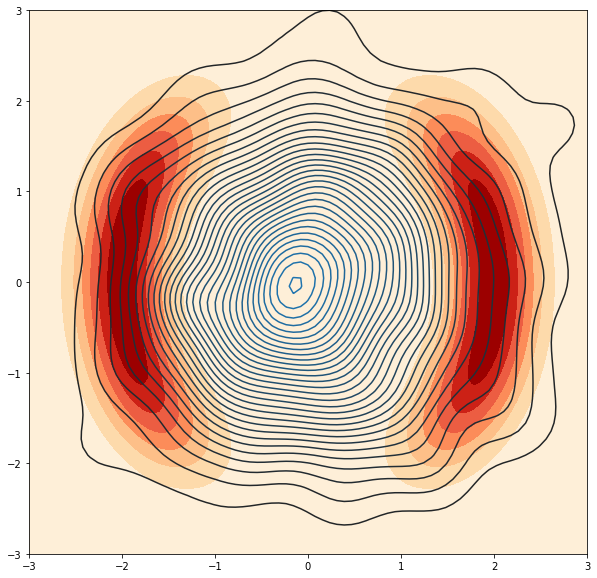

In [4]:
x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)
X1, X2 = np.meshgrid(x1, x2)
P = np.exp(DualMoonDistribution().log_prob(np.stack([X1, X2], axis=-1)))

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.contourf(X1, X2, P, cmap='OrRd')
sns.kdeplot(svgd.get_params(svgd_state)['auto_x'][:, 0], svgd.get_params(svgd_state)['auto_x'][:, 1], n_levels=30, ax=ax)


In [5]:
rng_key = jax.random.PRNGKey(142)

num_iterations = 250
svgd_state, loss = svgd.train(rng_key, num_iterations, callbacks=[Progbar()])

Stein 0.77093: 100%|██████████| 250/250 [01:46<00:00,  2.35it/s]


/usr/local/Caskroom/miniconda/base/envs/numpyro-stein/lib/python3.8/site-packages/jax/lax/lax.py:5605: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


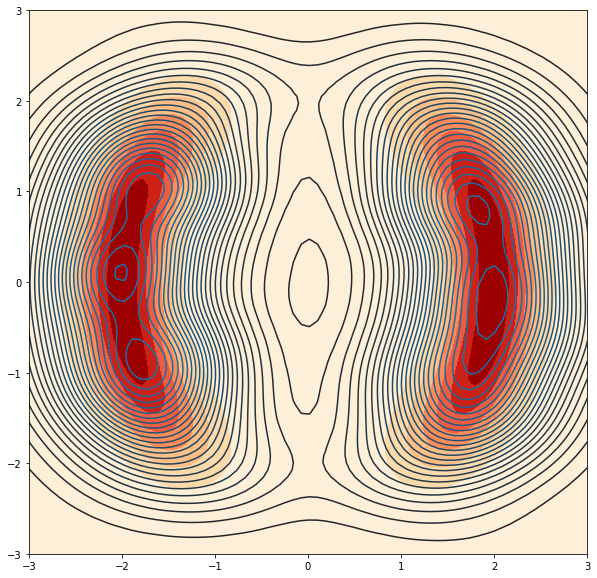

In [6]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.contourf(X1, X2, P, cmap='OrRd', )
sns.kdeplot(svgd.get_params(svgd_state)['auto_x'][:, 0], svgd.get_params(svgd_state)['auto_x'][:, 1], n_levels=30, ax=ax)

In [7]:
def make_iafs(num_iaf, input_dim, hidden_dims):
   flows = []
   for i in range(num_iaf):
       arn = AutoregressiveNN(input_dim, hidden_dims, permutation=jnp.arange(input_dim),
                              nonlinearity=stax.Elu)
       arnn = numpyro.module(f'arn_{i}', arn, (input_dim,))
       flows.append(InverseAutoregressiveTransform(arnn))
       if i < num_iaf - 1:
           flows.append(PermuteTransform(jnp.arange(input_dim)[::-1]))
   return flows

In [8]:
def neural_transport_guide(num_iaf=3, hidden_dims=[2,2]):
    flows = make_iafs(num_iaf, 2, hidden_dims)
    particle = numpyro.param('particle', init_value=jnp.array([0.,0.]))
    tparticle = ComposeTransform(flows)(particle)
    numpyro.sample('x', dist.Delta(tparticle))

In [9]:
rng_key = jax.random.PRNGKey(142)
guide = WrappedGuide(neural_transport_guide)
svgd = Stein(dual_moon_model,
            guide,
            Adam(step_size=0.01), ELBO(), RBFKernel(), num_particles=1000,
            classic_guide_params_fn=lambda name: name.startswith("arn"))
svgd_state = svgd.init(rng_key)

In [10]:
num_iterations = 250
svgd_state, loss = svgd.train(rng_key, num_iterations, callbacks=[Progbar()])

Stein 0.10562: 100%|██████████| 250/250 [01:46<00:00,  2.35it/s]


/usr/local/Caskroom/miniconda/base/envs/numpyro-stein/lib/python3.8/site-packages/jax/lax/lax.py:5605: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


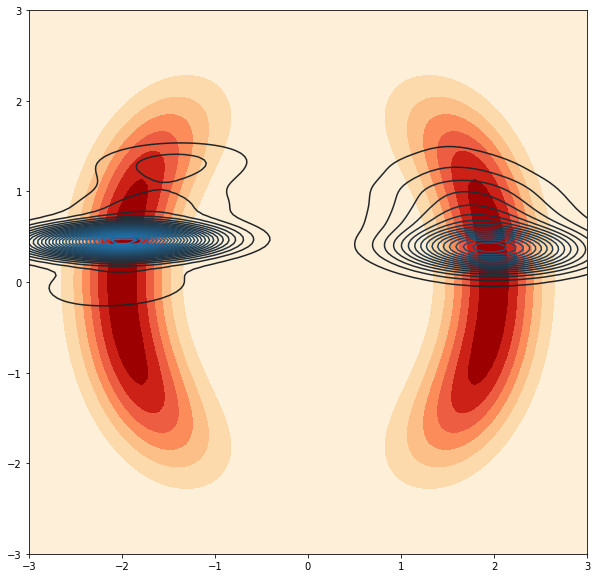

In [11]:
samples = svgd.predict(svgd_state)
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.contourf(X1, X2, P, cmap='OrRd')
sns.kdeplot(samples['x'][:, 0], samples['x'][:, 1], n_levels=30, ax=ax)

## Neal's Funnel

In [12]:
def funnel_pdf(pos):
    prob = dist.Normal(0,3).log_prob(pos[:,:,1]) + dist.Normal(0, jnp.exp(pos[:,:,1]/2)).log_prob(pos[:,:,0])
    return jnp.exp(prob)
x, y = jnp.meshgrid(jnp.linspace(-20, 20, 500), jnp.linspace(-9, 9, 100))
probs = funnel_pdf(jnp.stack([x, y], axis=-1))
probs

DeviceArray([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
              0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
             [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
              0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
             [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
              0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
             ...,
             [1.0822454e-05, 1.0825530e-05, 1.0828587e-05, ...,
              1.0828587e-05, 1.0825530e-05, 1.0822454e-05],
             [8.3337018e-06, 8.3356808e-06, 8.3376362e-06, ...,
              8.3376362e-06, 8.3356808e-06, 8.3337018e-06],
             [6.3874713e-06, 6.3887383e-06, 6.3899938e-06, ...,
              6.3899938e-06, 6.3887383e-06, 6.3874713e-06]],            dtype=float32)

### Normal Stein

In [13]:
def funnel(dim=10):
    y = numpyro.sample('y', dist.Normal(0, 3))
    numpyro.sample('x', dist.Normal(jnp.zeros(dim - 1), jnp.exp(y / 2)))

In [14]:
dim = 10
rng_key = jax.random.PRNGKey(142)
guide = AutoDelta(funnel, init_strategy=init_with_noise(init_to_value(values={'x': jnp.array([0.]*(dim-1)), 'y': jnp.array(1.)}), noise_scale=3.0))
svgd = Stein(funnel, guide, Adam(step_size=0.01), ELBO(),
            RBFKernel(mode='vector'), num_particles=100)
svgd_state = svgd.init(rng_key)

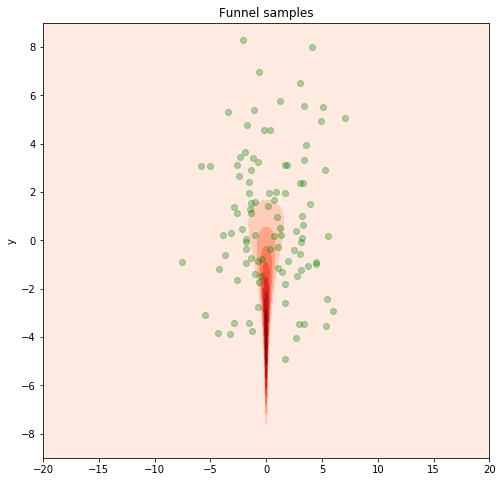

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.contourf(x,y,probs,cmap='Reds',)  # contour of funnel
ax.plot(svgd.get_params(svgd_state)['auto_x'][:, 0], svgd.get_params(svgd_state)['auto_y'], "go", alpha=0.3)
ax.set(xlim=(-20, 20), ylim=(-9, 9), ylabel='y', title='Funnel samples')
plt.show()

In [16]:
svgd_state, loss = svgd.train(rng_key, 10000, callbacks=[Progbar()])

Stein 4.1202: 100%|██████████| 10000/10000 [00:38<00:00, 256.54it/s]


/usr/local/Caskroom/miniconda/base/envs/numpyro-stein/lib/python3.8/site-packages/jax/lax/lax.py:5605: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


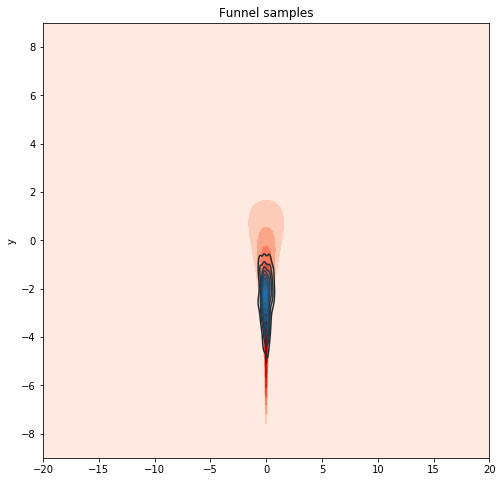

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.contourf(x,y,probs,cmap='Reds',)  # contour of funnel
sns.kdeplot(svgd.get_params(svgd_state)['auto_x'][:, 0], svgd.get_params(svgd_state)['auto_y'], ax=ax)
ax.set(xlim=(-20, 20), ylim=(-9, 9), ylabel='y', title='Funnel samples')
plt.show()

### Neural Transport Stein

In [18]:
def neural_transport_guide(num_iaf=3, hidden_dims=[dim,dim]):
    flows = make_iafs(num_iaf, dim, hidden_dims)
    particle = numpyro.param('particle', np.zeros(dim))
    tparticle = ComposeTransform(flows)(particle)
    numpyro.sample('y', dist.Delta(tparticle[0]))
    numpyro.sample('x', dist.Delta(tparticle[1:]))

In [19]:
dim = 10
rng_key = jax.random.PRNGKey(142)
guide = WrappedGuide(neural_transport_guide, lambda site: site['name'].endswith("$params"),
                     init_strategy=jax.partial(init_with_noise, jax.partial(init_to_value, values={'particle': np.zeros(dim)}), noise_scale=3.0))
svgd = Stein(funnel, guide, Adam(step_size=3e-4), ELBO(),
            RBFKernel(), num_particles=100,
            classic_guide_params_fn=lambda name: name.startswith("arn"))
svgd_state = svgd.init(rng_key)

In [20]:
svgd_state, loss = svgd.train(rng_key, 10000, callbacks=[Progbar()])

Stein 17.938: 100%|██████████| 10000/10000 [00:46<00:00, 215.72it/s]  


/usr/local/Caskroom/miniconda/base/envs/numpyro-stein/lib/python3.8/site-packages/jax/lax/lax.py:5605: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


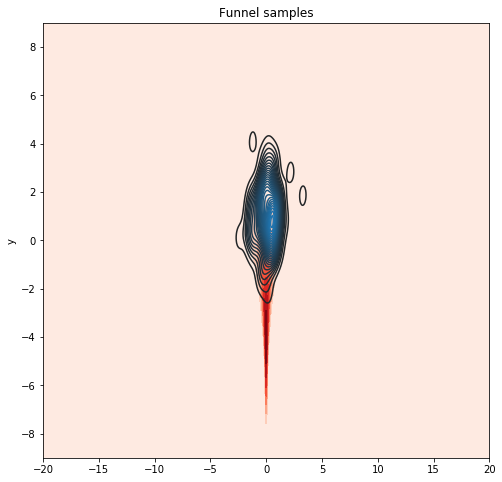

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.contourf(x,y,probs,cmap='Reds',)  # contour of funnel
samples = svgd.predict(svgd_state)
sns.kdeplot(samples['x'][:, 0], samples['y'], n_levels=30, ax=ax)
ax.set(xlim=(-20, 20), ylim=(-9, 9), ylabel='y', title='Funnel samples')
plt.show()